In [23]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import os
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
import datetime

In [24]:
# Funciones que nos pueden echar la mano

#Función para preparar base de datos de ventas por unidades

def preparar_data(year_number, month_number, day_number, shop_name, file_path, file_pattern):
    
    # Identificar los reportes de ventas de la carpeta en la que deben de guardarse al ser descargados
    final_paths = []
    files = []
    for day in day_number:
        paths_d = file_pattern.replace('?',day)
        for month in month_number:
            paths_m = paths_d.replace('$', month)
            for year in year_number:
                paths_y = paths_m.replace('#', str(year))
                for shop in shop_name:
                    paths_s = paths_y.replace('%', shop)
                    for file in os.listdir(file_path):
                        if file.endswith(".xls"):
                            if file in paths_s:
                                final_paths.append(paths_s)
                                
    # Con base en el nombre del archivo, agregar columnas que identifiquen fecha y tienda a la que corresponde (Tiendas: Renato Leduc- tienda física, Informatécnica - tienda online)
    # Primero, Renato Leduc (Tienda física)
    data_rl = pd.DataFrame()
    for f in final_paths:
        if "RL" in f:
            data = pd.read_excel(f)
            date = re.findall('\d{8}',f)
            # regex meaning: starts with...?<=, ends with...?=
            shop = re.findall('(?<=\-\s)(.*?)(?=\s\-)',f)
            data['Fecha'] = date*(len(data))
            data['Tienda'] = shop*(len(data))
            # index meaning: from row 5 to the penultimate row
            data_rl = data_rl.append(data[6:-1])
            
    # Actualización de los nombres de las columnas
    old_columns = list(data_rl.columns)
    new_columns = ['Clave principal', 'Unnamed: 1', 'Descripción del Producto',
           'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Tipo de Unidad', 'Unnamed: 7',
           'Unnamed: 8', 'Número de Unidades', 'Unnamed: 10', 'Unnamed: 11', 'Venta',
           'Fecha', 'Tienda', 'Informatécnica S.A. de C.V.']
    final_columns_names = dict(zip(old_columns, new_columns))
    data_rl = data_rl.rename(columns=final_columns_names)
    data_rl = data_rl[['Clave principal','Descripción del Producto','Tipo de Unidad','Número de Unidades','Venta','Fecha', 'Tienda']]
    
    #Agregar data importante de clasificación a nuestros registros de venta: talla, color, género, tipo, temporada
    data_clasificadores = pd.read_excel('C:/Users/Sofía Aceves Osuna/Dropbox/Nueva Renato Leduc/Clasificadores.xlsx')
    
    #Referencia merge: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    final_data_ventas_clasif= pd.merge(data_rl, data_clasificadores, how='left', on=['Clave principal'])
    
    # Seleccionar las columnas que nos queremos quedar
    final_data_ventas_clasif = final_data_ventas_clasif[['Clave principal', 'Descripción del Producto', 'Tipo de Unidad',
           'Número de Unidades','Fecha', 'Tienda', 'Talla', 'Género',
           'Material', 'Color', 'Tipo Final', 'Temporada','Costo', 'Venta']]
    
    # Eliminación de los productos que realmente no son productos que nos interesa comprar: como bolsas, bordados, gastos de envío y extintores
    servicios_extras = final_data_ventas_clasif[(final_data_ventas_clasif['Clave principal']=="BOLPABOAS")
                            |(final_data_ventas_clasif['Clave principal']=="BOLSE")
                            |(final_data_ventas_clasif['Clave principal']=="BOR1")
                            |(final_data_ventas_clasif['Clave principal']=="BOR2")
                            |(final_data_ventas_clasif['Clave principal']=="BORDESP")
                            |(final_data_ventas_clasif['Clave principal']=="BORDSEN")
                            |(final_data_ventas_clasif['Clave principal']=="GTOENV001")
                            |(final_data_ventas_clasif['Clave principal']=="GUIAESP")
                            |(final_data_ventas_clasif['Clave principal']=="REDPACK1")
                            |(final_data_ventas_clasif['Clave principal']=="SER04")
                            |(final_data_ventas_clasif['Clave principal']=="SERALCOS")
                            |(final_data_ventas_clasif['Clave principal']=="PQS02")
                            |(final_data_ventas_clasif['Clave principal']=="PQS04")
                            |(final_data_ventas_clasif['Clave principal']=="PQS15")
                            |(final_data_ventas_clasif['Clave principal']=="PQS20")
                            |(final_data_ventas_clasif['Clave principal']=="BZPWT20")
                            |(final_data_ventas_clasif['Clave principal']=="COJGALO")]
    cond = final_data_ventas_clasif['Clave principal'].isin(servicios_extras['Clave principal'])
    final_data_ventas_clasif.drop(final_data_ventas_clasif[cond].index, inplace = True)
    
    #Agregar columna de utilidad para visualizar la ganancia real
    final_data_ventas_clasif['Utilidad']=(final_data_ventas_clasif['Venta'])-(final_data_ventas_clasif['Costo'])
    
    #Cambiar tipo de datos: Número de Unidades - int64, Venta - float, fecha - date
    final_data_ventas_clasif = final_data_ventas_clasif.astype({"Número de Unidades": int, "Venta": float})
    final_data_ventas_clasif['Fecha'] = pd.to_datetime(final_data_ventas_clasif['Fecha'], format='%Y%m%d')
    
    #Agregar clave secundaria para poder hacer análisis de tiempo (y optimizar el historial de productos)
    catalogo_prod = pd.read_csv('C:/Users/Sofía Aceves Osuna/ironhack/final_project/catalogo_productos_sdt.csv')
    final_data_ventas_clasif = pd.merge(final_data_ventas_clasif,catalogo_prod[['Clave principal','Clave secundaria']],on='Clave principal')
    return final_data_ventas_clasif



    # Función para checar porcentaje de nulos de cada columna en nuestra base de datos
def percentage_nulls(df):
    number_nulls = pd.DataFrame(df.isnull().sum(),columns=['Total'])
    number_nulls['% nulls'] = round((number_nulls['Total'] / df.shape[0])*100,1)
    return number_nulls




    # Función para descurbir cuáles son los proudctos de los cuales nos interesa sacar serie de tiempo (serán siempre los de las temporadas que estén disponibles para compra - al día de hoy G5 y G10)
def tipo_producto_interesante(final_data_ventas_clasif):
    tipo_producto_raw = list(final_data_ventas_clasif[(final_data_ventas_clasif['Temporada']=='G10')|(final_data_ventas_clasif['Temporada']=='G5')]['Tipo Final'])
    tipo_producto = []
    [tipo_producto.append(x) for x in tipo_producto_raw if x not in tipo_producto]
    return tipo_producto




    #Función para observar la tendencia de unidades vendidas del producto que se introduzca

def grafica_tendencia (tipo_producto_interesante, start_date_obs, start_date_pred, stationarity, a,b,c,d,e,f,g, numero_lags):
    ventas_tipo = final_data_ventas_clasif[final_data_ventas_clasif['Tipo Final']== tipo_producto_interesante ][['Fecha', 'Número de Unidades']]
    ventas_tipo_sum = ventas_tipo.groupby(['Fecha']).sum()
    ventas_tipo_sem = ventas_tipo_sum['Número de Unidades'].resample('W-MON').sum()
    ventas_tipo_sem.plot(style=[':','--','-'])
    ax = ventas_tipo_sem.plot(x='Fecha', y='Número de Unidades', figsize=(12,6))
    #xcoords = ['2020-01','2020-02', '2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08']
    xcoords = ['2020-01','2020-02','2020-04','2020-05','2020-07','2020-09','2021-01','2021-02','2021-04','2021-05','2021-07']
    for xc in xcoords:
        plt.axvline(x=xc, color='black', linestyle='--')
    # Augmented Dickey Fuller Test: para probar si nuestros datos son estacionarios o no - estacionarios: pvalue <0.05 y valores críticos confirman
    dftest = adfuller(ventas_tipo_sem, autolag = None)
    print(f'Prueba estadistica{dftest[0]}')
    print(f'P-value={dftest[1]}')
    print(f'Valores criticos:')
    for k, v in dftest[4].items():
        print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))
    
    # Este estimador nos permite encontrar los mejores parámetros para Sarimax
    p = d = q = range(0,2) # porque así lo indica la fórmula
    # AIC(Arkaike Information Criteria)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],12) for x in list( itertools.product(p,d,q))]
    print(f'Sarimax: {pdq[1]} x {seasonal_pdq[1]}')
    
    #Acción para encontrar los parámetros adecuados (si los datos resultaron con valor de pvalue >.05 y valores críticos que indican no estacionariedad, poner enforce_starionarity = True)
    for param in pdq:
        for param_estacional in seasonal_pdq:
            try:
                mod= sm.tsa.statespace.SARIMAX(
                ventas_tipo_sem,
                order=param,
                seasonal_order=param_estacional,
                enforce_stationarity = stationarity
                )
                results = mod.fit()
                print(f'ARIMA {param} x {param_estacional}12 - AIC:{results.aic}')
            except:
                continue
    #Entrenar modelo de series de tiempo con los parámetros encontrados (Parámetros estándar: 1,1,1 - 1,1,1,12 pueden cambiar de acuerdo al último resultado arrojado en la prueba de parámetros)
    mod= sm.tsa.statespace.SARIMAX(
              ventas_tipo_sem,
              order=(a, b, c),
              seasonal_order=(d, e, f, g),
              enforce_stationarity = stationarity
          )
    resultados = mod.fit()
    #Gráficos que nos permiten revisar cómo se comporta nuestro modelo
    print('Nos importa que:\n Standarized residual: Lo más pegada a 0\n Histogram: Se distribuya de manera normal\n Normal Q-Q: Que no haya muchos puntos alejados de la línea')
    resultados.plot_diagnostics(figsize=(22,10))
    plt.show()
    
    #Hacer proyecciones prueba a futuro con nuestro modelo con datos que ya conocemos
    predicciones = resultados.get_prediction(start=pd.to_datetime(start_date_pred)) #a partir de qué fecha quieres que haga predicción
    pred_conf_int = predicciones.conf_int()
    ax = ventas_tipo_sem[start_date_obs:].plot(label='Observados')
    predicted_mean = predicciones.predicted_mean
    predicted_mean = predicted_mean.to_frame()
    predicciones.predicted_mean.plot(ax=ax, label ='Pronóstico', alpha =.7, figsize=(14,7))
    ax.fill_between(pred_conf_int.index,
    pred_conf_int.iloc[:,0],
    pred_conf_int.iloc[:,1],
    color='gray',
    alpha=.2)
    plt.legend()
    plt.ylabel('Unidades vendidas')
    plt.show()
    
    #Hacer proyecciones prueba a futuro con nuestro modelo para datos que no conocemos
    prediccion_futurista = resultados.get_forecast(steps=numero_lags)# cuántos lags quieres que prediga- lo tenemos por semana
    pred_ci=prediccion_futurista.conf_int()
    ax = ventas_tipo_sem.plot(label='Pasado')
    prediccion_futurista.predicted_mean.plot(ax=ax, label ='Pronóstico futuro', alpha =.7, figsize=(14,7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:,0],
                    pred_ci.iloc[:,1],
                    color='gray',
                    alpha=.2)
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.show()


def predicted_df (tipo_producto_interesante, start_date_obs, start_date_pred, stationarity, a,b,c,d,e,f,g, numero_lags):
    ventas_tipo = final_data_ventas_clasif[final_data_ventas_clasif['Tipo Final']== tipo_producto_interesante ][['Fecha', 'Número de Unidades']]
    ventas_tipo_sum = ventas_tipo.groupby(['Fecha']).sum()
    ventas_tipo_sem = ventas_tipo_sum['Número de Unidades'].resample('W-MON').sum()
    mod= sm.tsa.statespace.SARIMAX(
              ventas_tipo_sem,
              order=(a, b, c),
              seasonal_order=(d, e, f, g),
              enforce_stationarity = stationarity
          )
    resultados = mod.fit()
    #Hacer proyecciones prueba a futuro con nuestro modelo con datos que ya conocemos
    predicciones = resultados.get_prediction(start=pd.to_datetime(start_date_pred)) #a partir de qué fecha quieres que haga predicción
    pred_conf_int = predicciones.conf_int()
    #Hacer proyecciones prueba a futuro con nuestro modelo para datos que no conocemos
    prediccion_futurista = resultados.get_forecast(steps=numero_lags)# cuántos lags quieres que prediga- lo tenemos por semana
    pred_ci=prediccion_futurista.conf_int()
    predicted_mean = prediccion_futurista.predicted_mean
    predicted_mean = predicted_mean.to_frame()
    return predicted_mean

In [25]:
year_number = [20,21]
month_number = ['01','02','03','04','05','06','07','08','09','10','11','12']
day_number = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
shop_name = ['Informatécnica', 'RL']
file_path = "C:/Users/Sofía Aceves Osuna/Dropbox/Gallantdale/Reportes/Reportes de Ventas Semanales"
file_pattern = "C:/Users/Sofía Aceves Osuna/Dropbox/Gallantdale/Reportes/Reportes de Ventas Semanales/20#$? - % - Ventas por artículo.xls"

final_data_ventas_clasif = preparar_data(year_number, month_number, day_number, shop_name, file_path, file_pattern)

WARNING *** file size (42513) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (45886) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (44936) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (18408) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (46092) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (37813) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (19428) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero

In [26]:
# Productos que se venden más
final_data_ventas_clasif.pivot_table(index=['Tipo Final'],values=['Número de Unidades','Utilidad'], aggfunc= {'Número de Unidades':'sum', 'Utilidad':'sum'}).sort_values(by='Número de Unidades', ascending=False)

,Número de Unidades,Utilidad
Tipo Final,,
PIJAMA,12422,4050600.770
FILIPINA,2921,342053.398
BATA,2177,597063.990
PANTALON,1514,195252.270
CUBRE,1463,63699.530
GORRO,1410,80266.930
OVEROL,739,277677.190
OTRO,204,28247.890


In [27]:
# Productos que dejan más
final_data_ventas_clasif.pivot_table(index=['Tipo Final'],values=['Número de Unidades','Utilidad'], aggfunc= {'Número de Unidades':'sum', 'Utilidad':'sum'}).sort_values(by='Utilidad', ascending=False)

,Número de Unidades,Utilidad
Tipo Final,,
PIJAMA,12422,4050600.770
BATA,2177,597063.990
FILIPINA,2921,342053.398
OVEROL,739,277677.190
PANTALON,1514,195252.270
GORRO,1410,80266.930
CUBRE,1463,63699.530
OTRO,204,28247.890


In [28]:
tipo_producto_interesante(final_data_ventas_clasif)

['BATA', 'CUBRE', 'FILIPINA', 'GORRO', 'OVEROL', 'PANTALON', 'PIJAMA', 'OTRO']

Prueba estadistica-1.814035579196833
P-value=0.37351601847666605
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:1126.3916917676534
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1076.2119858389226
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:867.0064619734533
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:859.321917751271
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:1012.9161368107387
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:1009.5801292848348
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:861.0272499351883
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:858.50455092318
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:1044.2408172887228
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:1013.9838151774177
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:842.5899682030338
ARIMA (0, 0

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


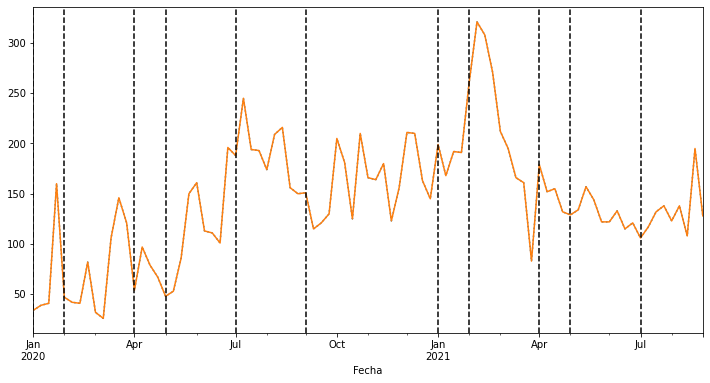

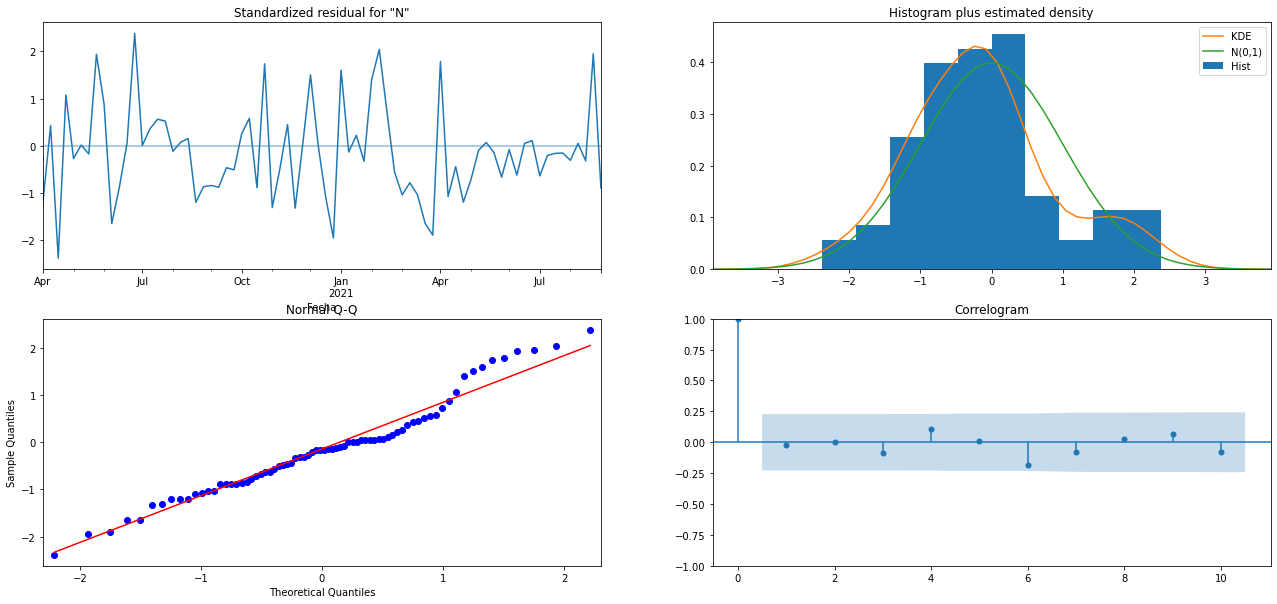

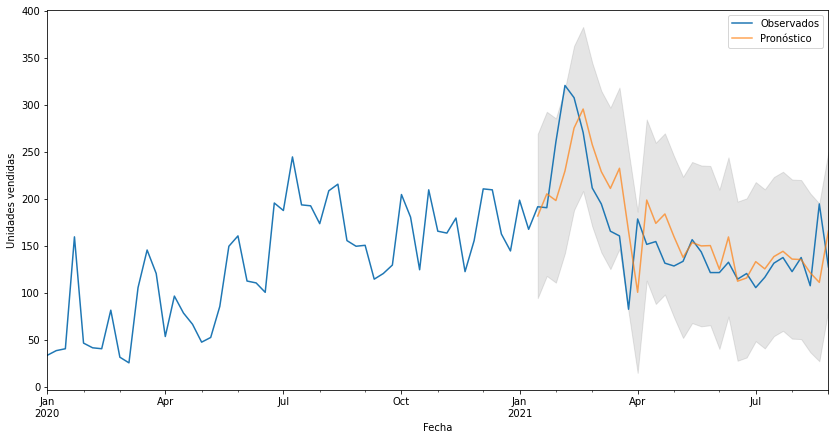

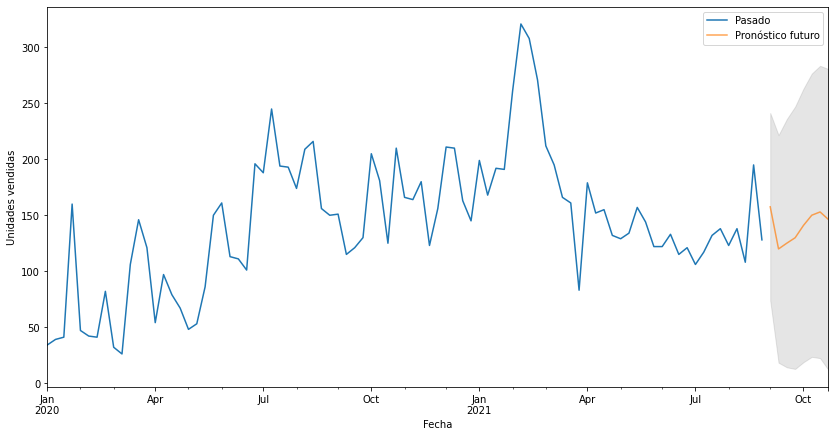

In [29]:
#Se correrá ésta función para cada uno de los productos identificados en tipo_producto_interesante
#Descripción de la función por posición de elementos:
#1: Producto interesante seleccionado
#2: Desde qué fecha quieres empezar a ver resultados de ventas (ventas que ya conocemos)
#3: Desde qué fecha quieres empezar a predecir ventas (ventas que no conocemos)
#4: Si dftest nos arroja de resultado estacionarios (pvalue <0.05 y valores críticos confirman resultado) cambiar a False
#5-11: Si el último AIC se detiene en parámetros diferentes, cambiar parámetros
#12: Indica el número de semanas del que quieres predecir la venta

grafica_tendencia('PIJAMA', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [30]:
final_predictions_pijama = predicted_df('PIJAMA', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_pijama['Tipo Final'] = 'PIJAMA'

Prueba estadistica-2.233910925176414
P-value=0.19416870136549458
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:832.3177239568557
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:807.1266510476066
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:664.7833513092329
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:634.4004939307393
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:772.3581950167973
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:748.2554828726081
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:632.7367278392572


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:629.4689632815881
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:785.1291156543244
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:776.6953042912769
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:660.2930259688151
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:630.2913646287782
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:759.6769051920274
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:738.3904288448412
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:625.124196958172
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:624.3235625784756
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:727.2063239166554
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 - AIC:729.0586006952725
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 - AIC:673.8865572531627
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:646.002090322111
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:728.9446138146415
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:722.9066196327036
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:634.1809090364777
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:636.1113133965158
ARIMA (0, 1, 1) 

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:698.1072199038414
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 - AIC:618.9438608609787
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 - AIC:619.9670874665644
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 - AIC:732.1309960763689
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 - AIC:734.1096412454294
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 - AIC:656.613848261856
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 - AIC:627.7736442206228
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 - AIC:734.083567951755
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 - AIC:728.8620115828501
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 - AIC:620.4075410904487
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 - AIC:621.2614016742352


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA (1, 0, 1) x (0, 0, 0, 12)12 - AIC:708.8238794647333
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:710.6783118126981
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:653.1683971004621
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:626.4856841208409
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:710.6002115557772
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:712.4252730170841
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:620.1052477077336
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:621.1448165361887
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:706.1799165279932
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:708.1786476581897
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:652.4423533928863
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:628.648641344792
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:708.1778717881131


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:705.5321387178792
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:621.0749980712883
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:623.0013109477261
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:699.435750044871
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:701.3152100563659
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:650.3066059862649
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:625.708888972784
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:701.2545415822169


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:700.0375202682526
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 - AIC:620.8973502029739
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 - AIC:621.9663970725953
Nos importa que:
 Standarized residual: Lo más pegada a 0
 Histogram: Se distribuya de manera normal
 Normal Q-Q: Que no haya muchos puntos alejados de la línea


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


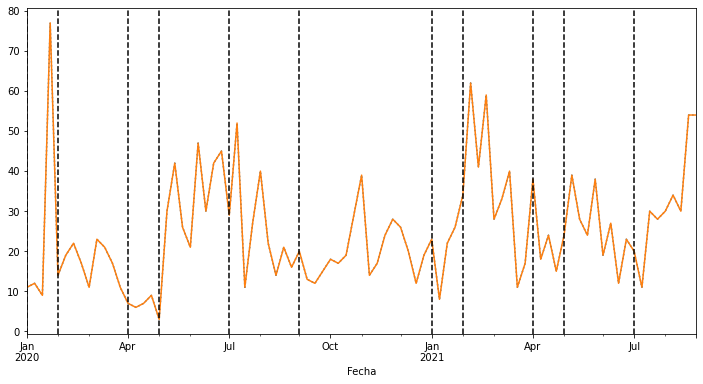

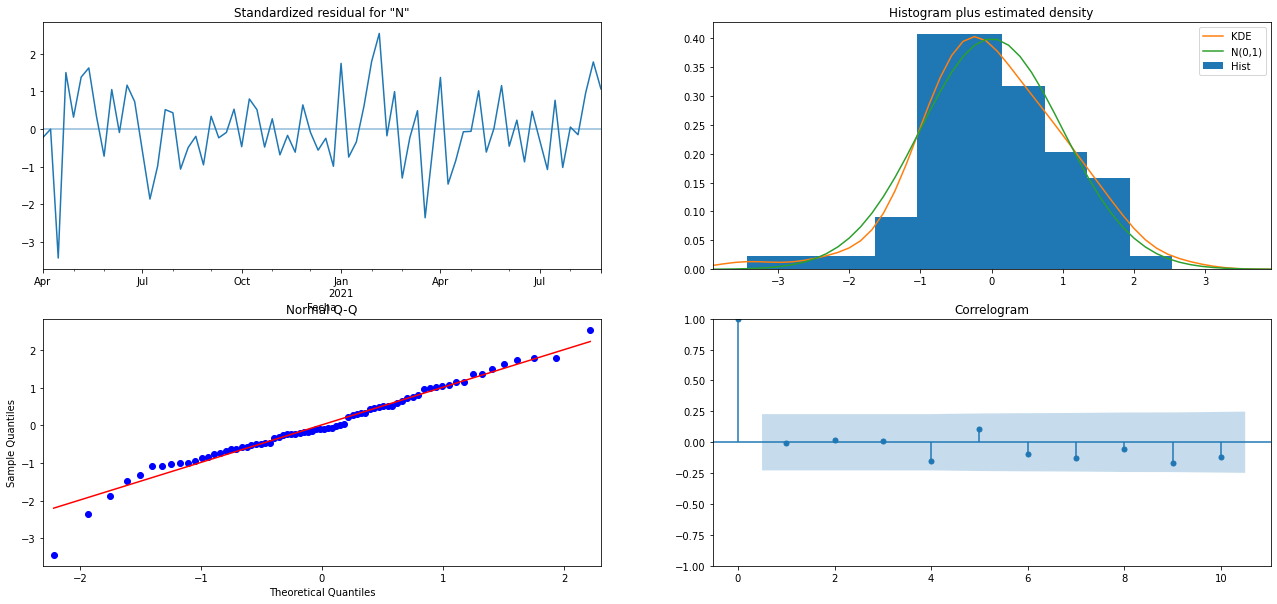

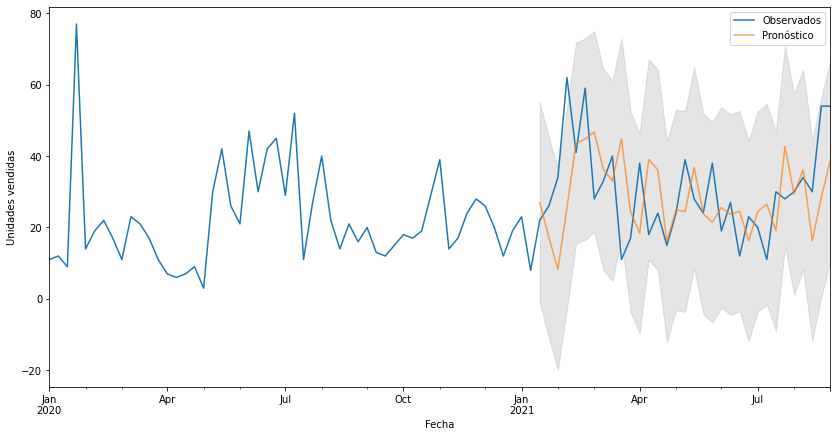

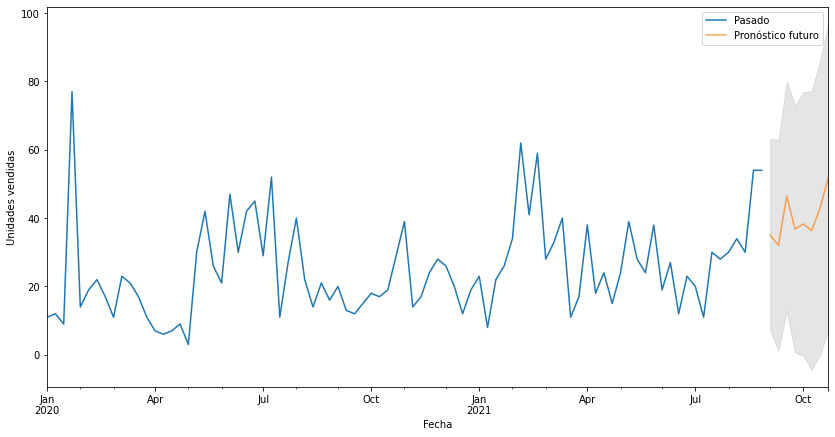

In [31]:
grafica_tendencia('BATA', '2020-01-06','2021-01-18',True, 1,1,1,1,1,1,12, 8)

In [32]:
final_predictions_bata = predicted_df('BATA', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_bata['Tipo Final'] = 'BATA'

Prueba estadistica-2.3731740053753754
P-value=0.14945141682416335
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:872.8762867464301
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:826.717419745693
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:649.6210606618473
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:628.9528450582893
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:767.1064327521588
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:749.6538853251052
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:636.8647287103296
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:630.9126437130477
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:822.7338344163537
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:794.0148550290628
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:647.9198357408949
ARIMA (0, 0, 1

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:711.5237209242315
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:643.7927407151134
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:629.5826911838252
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:711.52372241766
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:713.564986053815
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:634.3457341565007
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:631.2063381364235
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:719.1962921172228
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:721.0259146753885
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:653.5222489121004
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:644.4696823027826
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:721.0157573517323
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:723.0153807805722
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:644.7973692670328
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:646.1292906342818
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:699.3612418261672
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:701.3146108989329
ARIMA (1, 1, 1) x

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


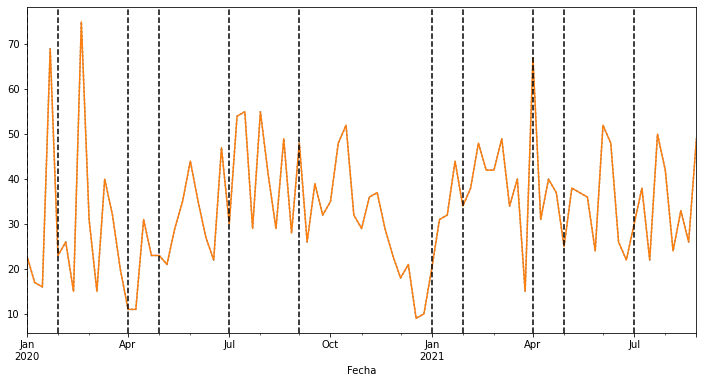

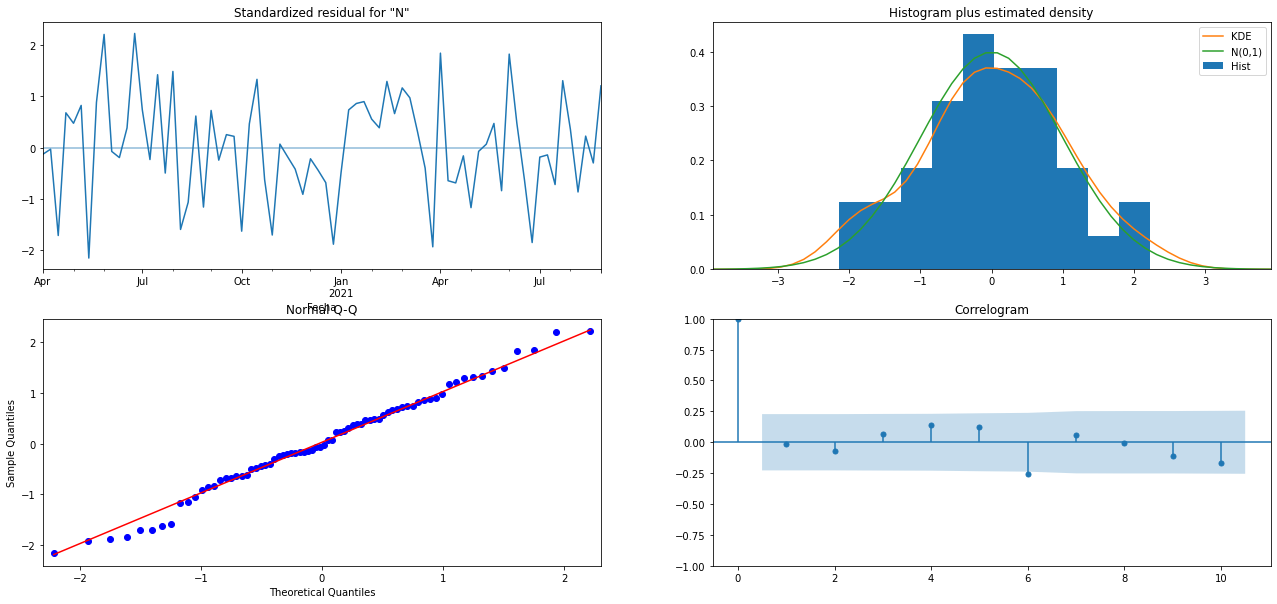

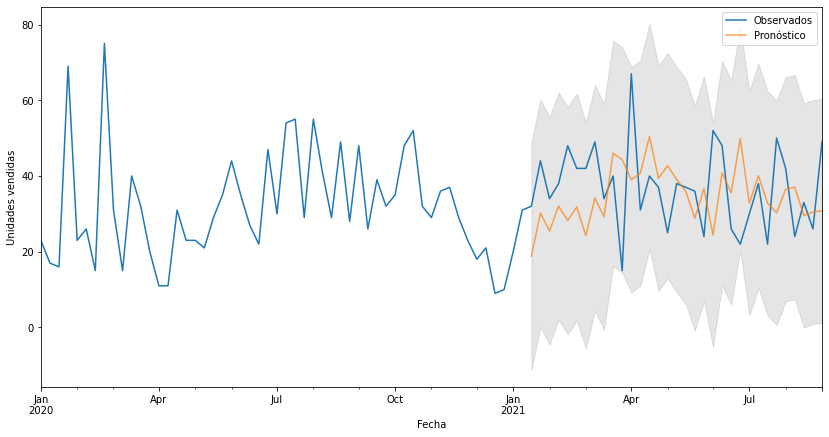

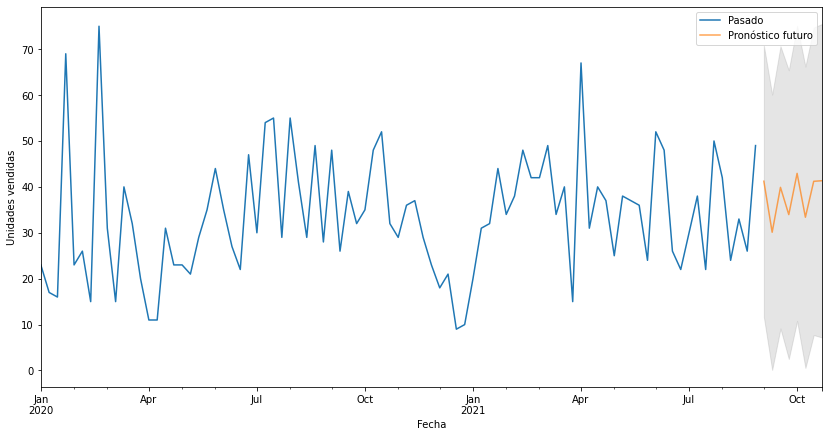

In [33]:
grafica_tendencia('FILIPINA', '2020-01-06','2021-01-18',True, 1,1,1,1,1,1,12, 8)

In [34]:
final_predictions_filipina = predicted_df('FILIPINA', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_filipina['Tipo Final'] = 'FILIPINA'

Prueba estadistica-2.0157634271540794
P-value=0.279704442203235
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:759.0482608395977
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:723.3285973744859
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:601.4993249057957
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:576.9442955484737
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:691.6644919493513
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:680.6119509331068
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:590.3894172132798
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:578.6515546011046
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:715.392473986548
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:701.8720960175717
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:601.5205809271682
ARIMA (0, 0, 1) 

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:593.4033096642094
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:554.6437586916888
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:626.4356220714429
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:626.8107169562763
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:573.4733265076196
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:555.407103158427
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:629.801284822388
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:631.7661973683713
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:597.2361508509271
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:558.0723607117319
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:631.7618243430906
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:630.8732165935915
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:577.4933892092189
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:559.0154612568281
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:615.5802010832308
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:617.5743973132195
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:587.2360721699418
ARIMA (1, 1, 1) 

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


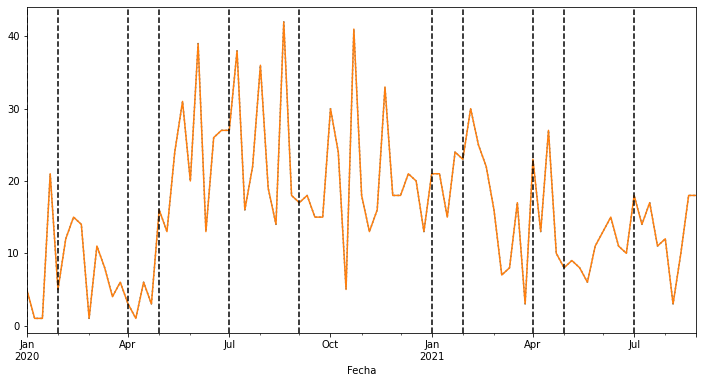

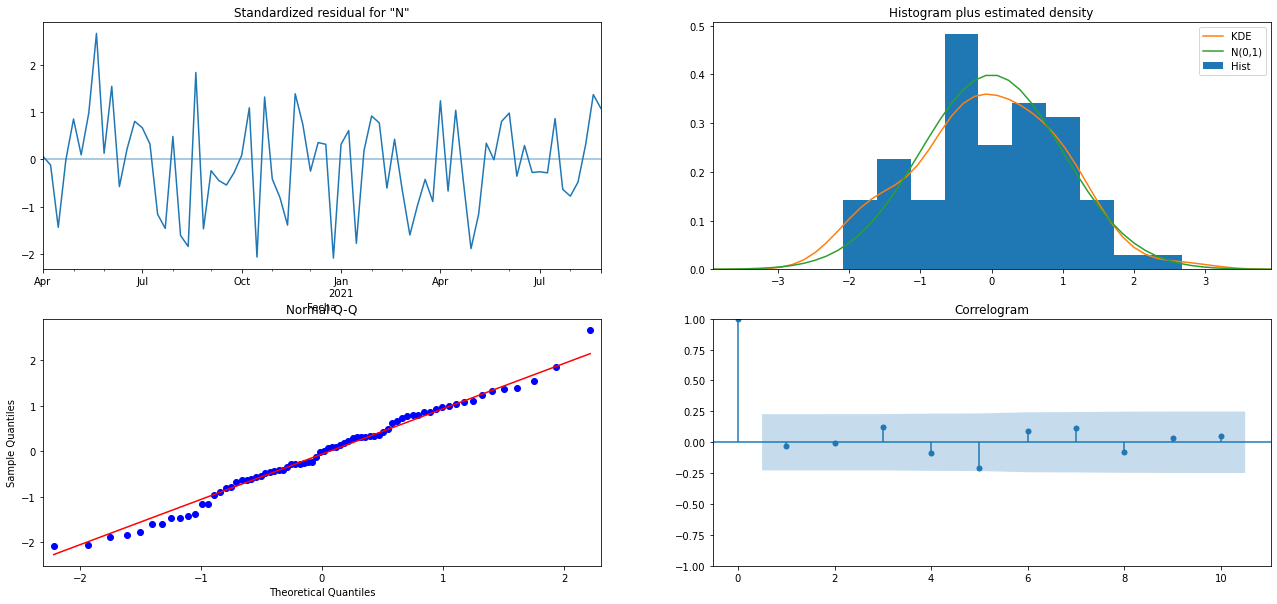

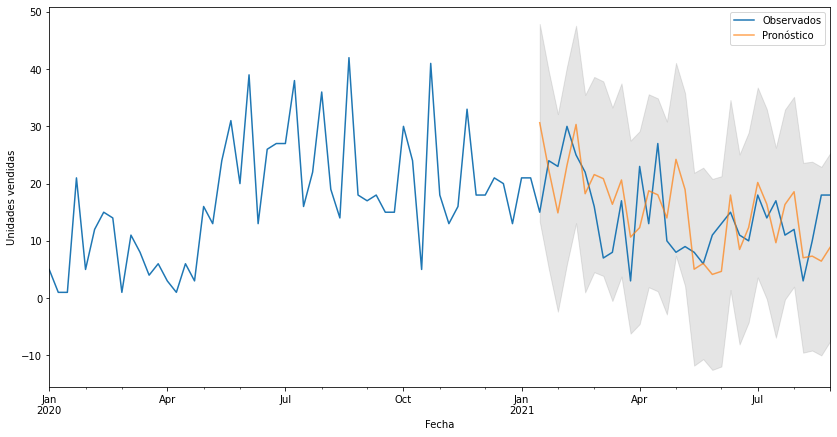

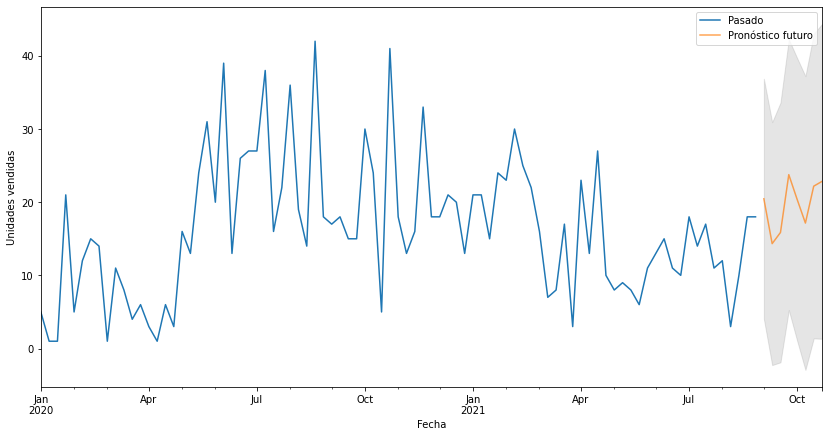

In [35]:
grafica_tendencia('GORRO', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [36]:
final_predictions_gorro = predicted_df('GORRO', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_gorro['Tipo Final'] = 'GORRO'

Prueba estadistica-2.117851699677523
P-value=0.23739719299110978
Valores criticos:
	1%:-3.5506699942762414 Los datos son not estacionarios con 99% de confianza
	5%:-2.913766394626147 Los datos son not estacionarios con 95% de confianza
	10%:-2.5946240473991997 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:574.9914226010137
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:564.8803140178709
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:472.12899056137746
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:463.73246559428554
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:560.8574871142114
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:558.8007050247378
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:465.4800983466862
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:465.508648764419
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:558.6371290554487
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:555.8087461441428
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:473.57052647295694
ARIMA (0, 0

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:478.09173640849724
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:550.3663994566397
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:551.412297916389
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:485.5873100274579
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:480.07651865322975
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 - AIC:512.461099183529
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 - AIC:514.4445776577627
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 - AIC:464.35819661951604
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 - AIC:449.3555057836668
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 - AIC:514.4479044488767
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:515.7024598923158
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 - AIC:453.2626072249066
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 - AIC:451.2771155412946
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 - AIC:543.83602399514
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 - AIC:545.448451285037
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 - AIC:473.36164227221246
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 - AIC:462.52912765345326
ARIMA (1, 0, 0

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:470.5711350449681
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:456.4088152304948
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:524.145377814296


c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:525.2987582024167
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:460.1036781684764
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:458.3958534823427
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:528.8783224567354
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:530.7491287759952
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:477.7704773275995
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:463.6122801454344
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:530.7803010634551
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:531.382581499544
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:467.4451971851033
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:465.4333801296037
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:514.0336708380207
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:516.0301435017223
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:464.97369449344836
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:451.1529724216308
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:516.0308145870627
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:517.1869506311791
ARIMA (1, 1, 1

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


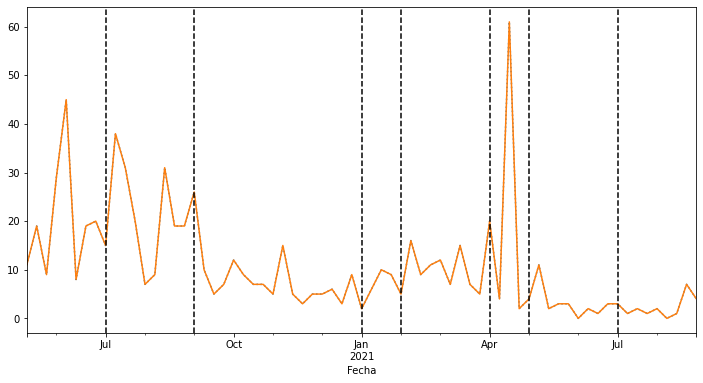

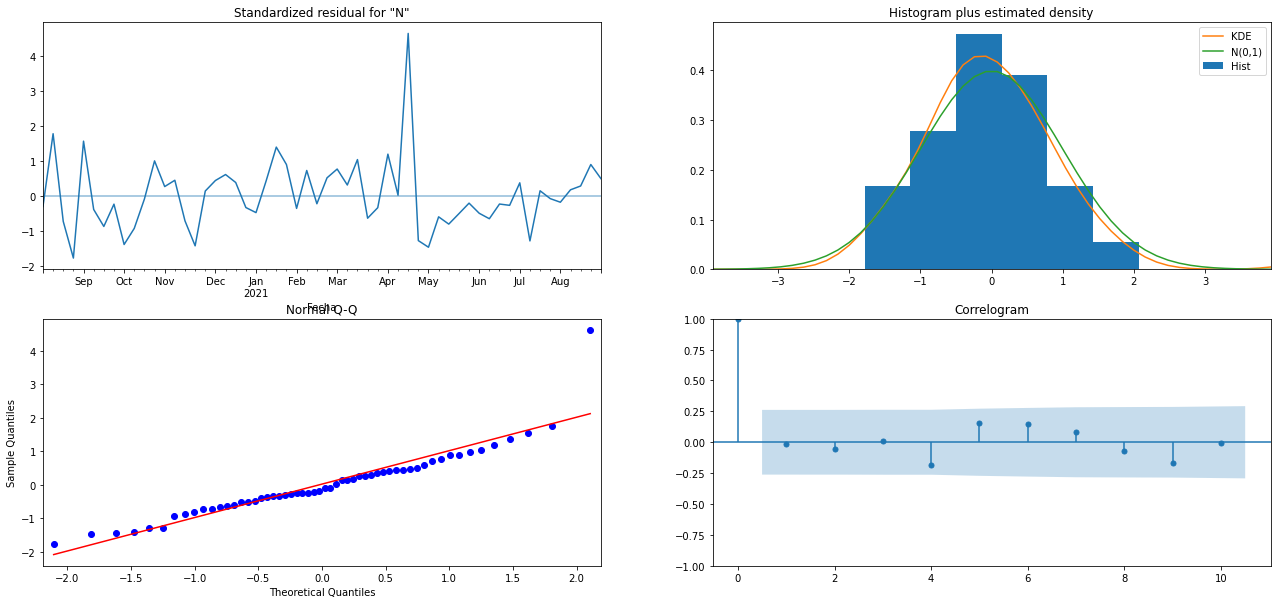

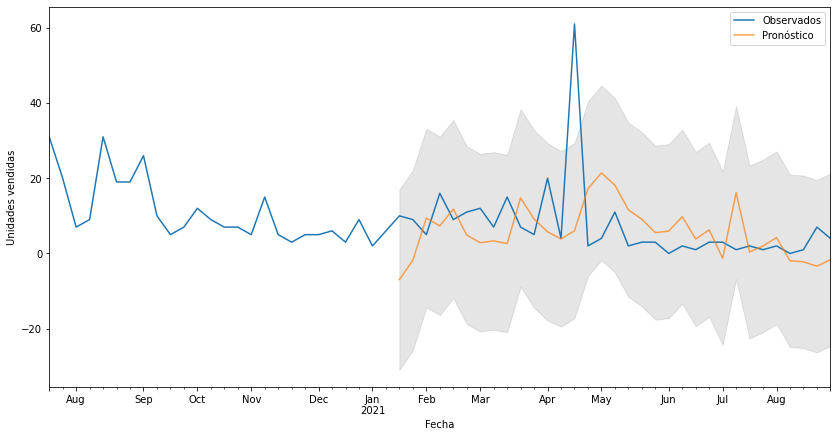

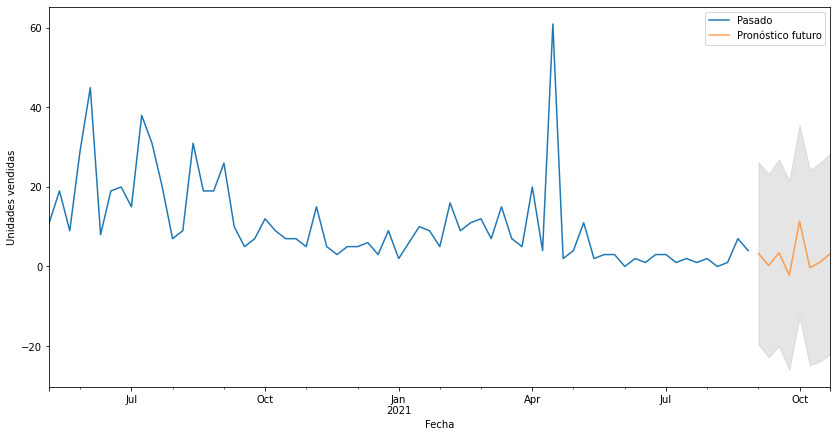

In [37]:
grafica_tendencia('OVEROL','2020-07-20','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [38]:
final_predictions_overol = predicted_df('OVEROL','2020-07-20','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_overol['Tipo Final'] = 'OVEROL'

Prueba estadistica-2.4157955666170117
P-value=0.1373277661349543
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:767.1877667548586
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:735.5492799818566
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:594.6555644346614
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:569.9215681640968
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:694.9743234486382
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:675.2875129231503
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:576.3462908705161
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:571.1980979885321
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:726.6361855136266
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:707.4489971013221
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:590.5799939697173
ARIMA (0, 0, 1

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:586.5607905382846
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:569.0394466698187
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:646.7309460054549
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:647.7414506774082
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:573.2710779741894
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:570.8357019092165
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:657.2372388703752
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:659.062261677882
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:598.7382937893589
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:585.0385381273514
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:658.9995318440727
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:660.5317190575504
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:586.0240776818259
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:586.377805422769
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:634.9892124479175
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:636.9594210124709
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:587.9878921975055
ARIMA (1, 1, 1) 

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


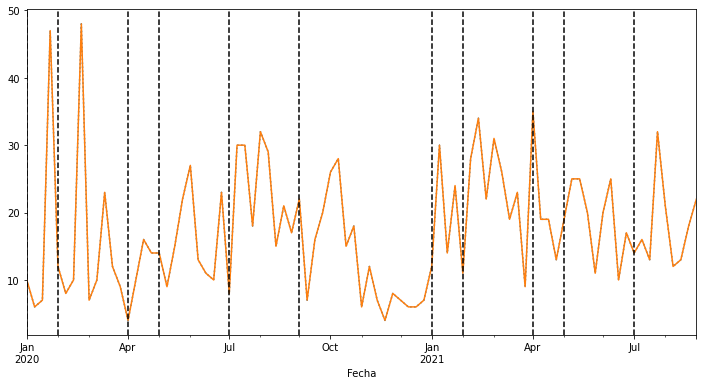

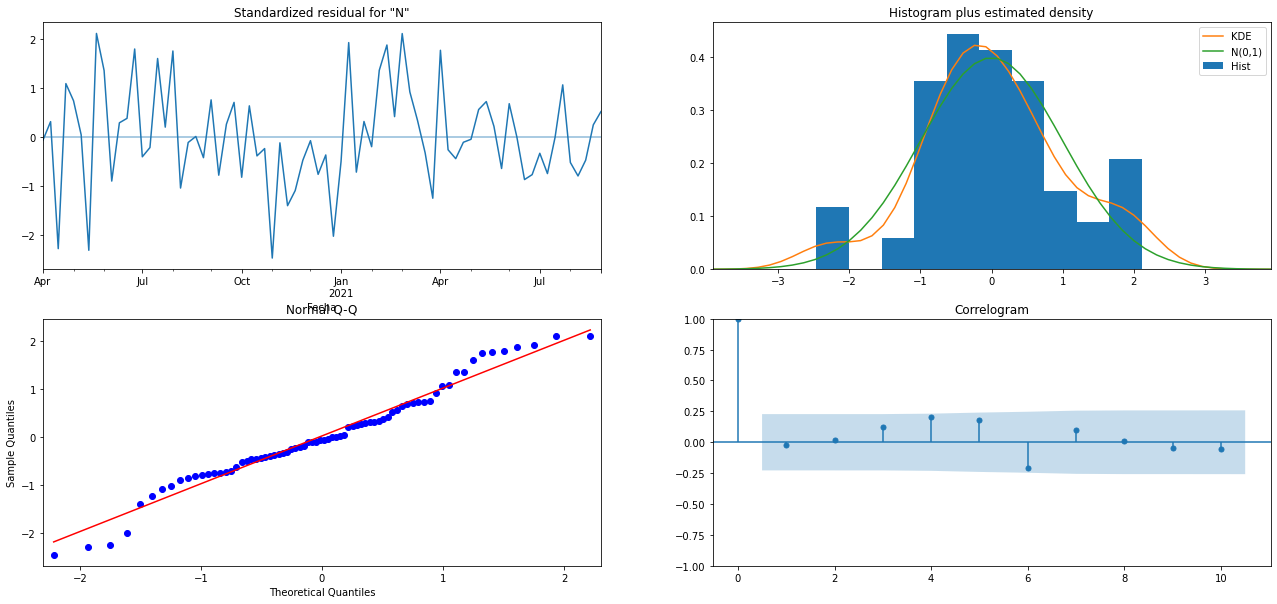

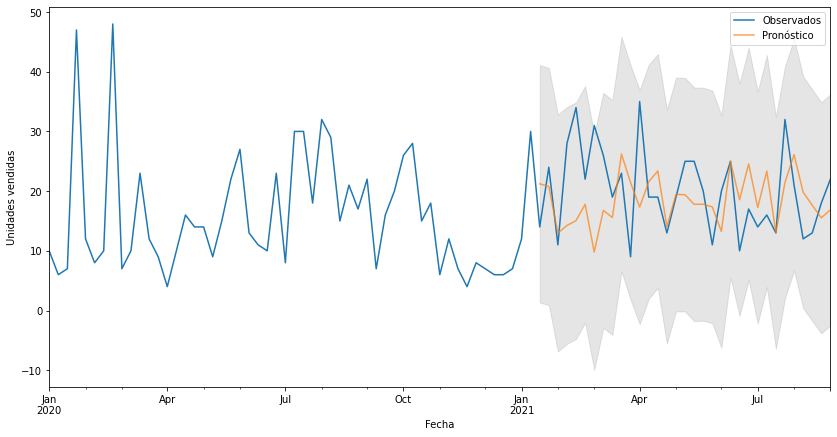

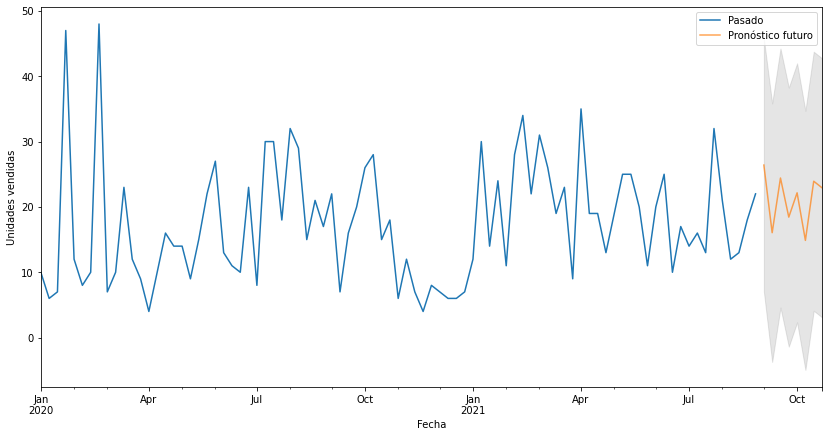

In [39]:
grafica_tendencia('PANTALON','2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [40]:
final_predictions_pantalon = predicted_df('PANTALON', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_pantalon['Tipo Final'] = 'PANTALON'

Prueba estadistica-2.0808007470806147
P-value=0.25230446249694727
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:869.3482788929578
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:865.0092827704711
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:785.442061819559
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:759.4416422437973
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:864.4219339508256
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:865.838391807975
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:764.4880877410751
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:761.2786412661138
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:853.539721920305
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:850.7620590673475
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:776.2535888004358
ARIMA (0, 0, 1) 

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


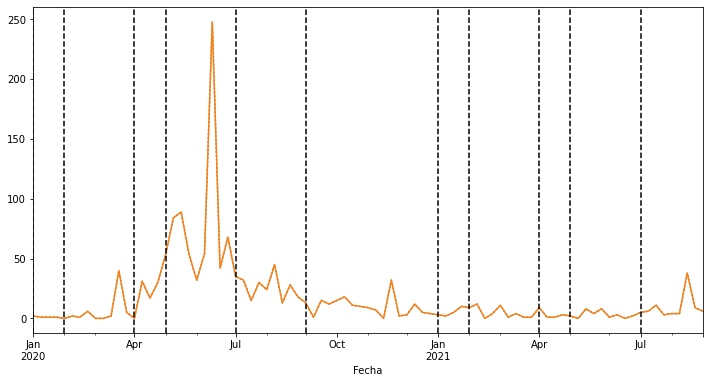

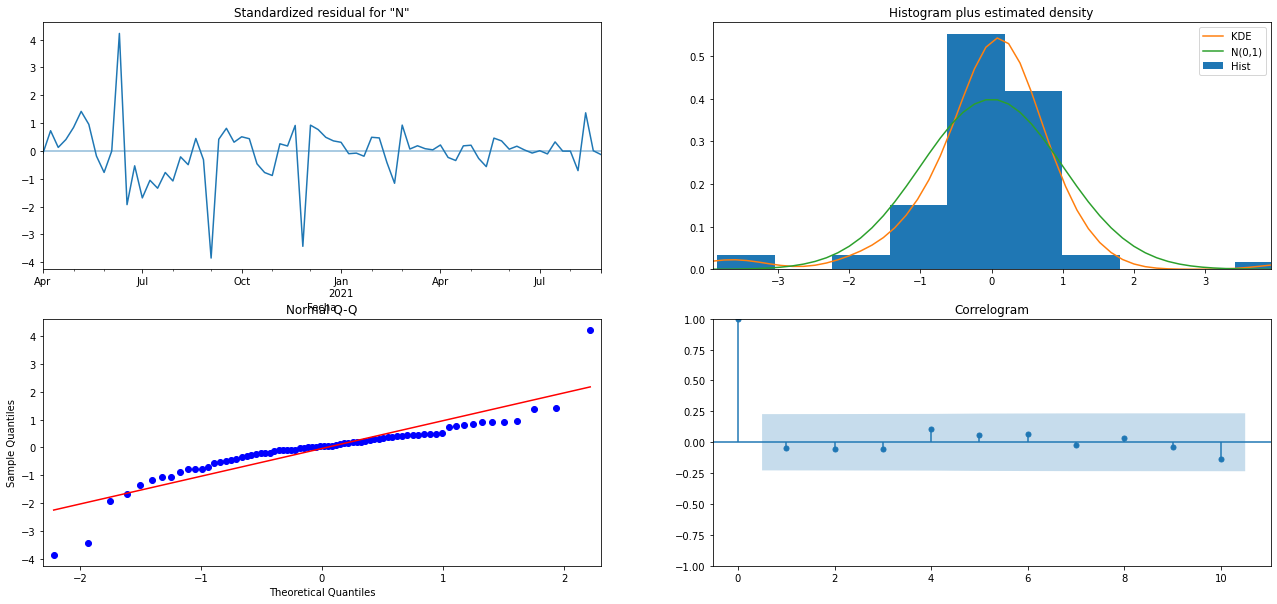

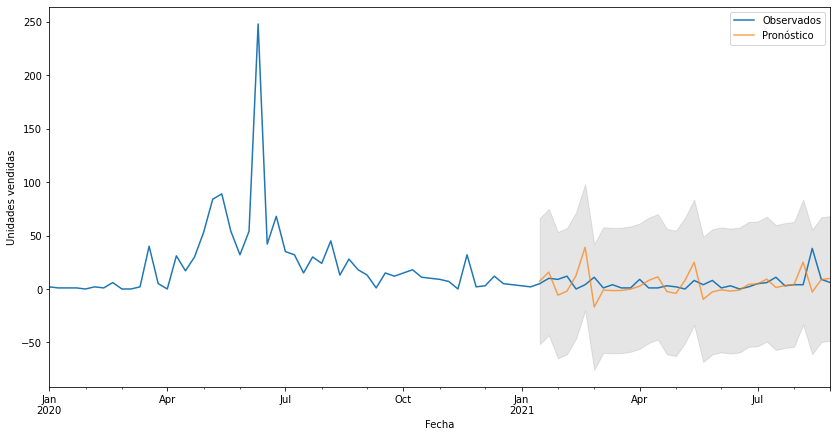

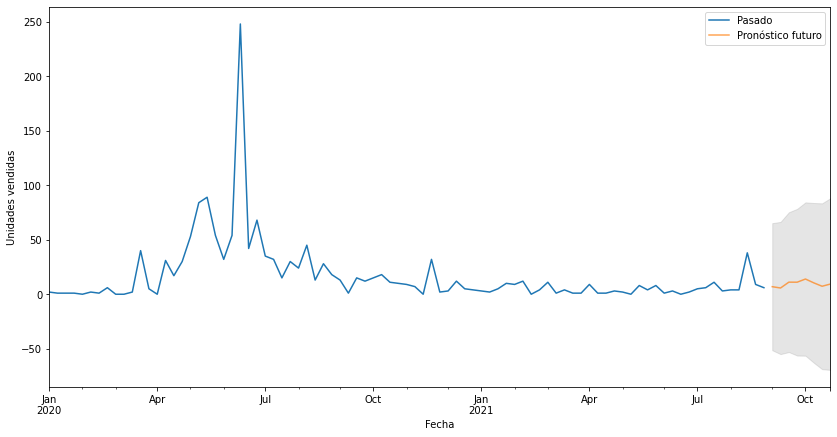

In [41]:
grafica_tendencia('CUBRE','2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [42]:
final_predictions_cubre = predicted_df('CUBRE', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_cubre['Tipo Final'] = 'CUBRE'

Prueba estadistica-0.8733660111071746
P-value=0.7966168089931259
Valores criticos:
	1%:-3.5219803175527606 Los datos son not estacionarios con 99% de confianza
	5%:-2.9014701097664504 Los datos son not estacionarios con 95% de confianza
	10%:-2.58807215485756 Los datos son not estacionarios con 90% de confianza
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:463.22925751110176
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:442.4164586397625
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:384.78486314526816
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:368.83905172663157
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:431.75052296579537
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:427.881321879612
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:373.13666961220576
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:370.8046549487548
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:445.83710025138896
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:433.9518385139792
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:386.3527669405508
ARIMA (0,

c:\users\sofía aceves osuna\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


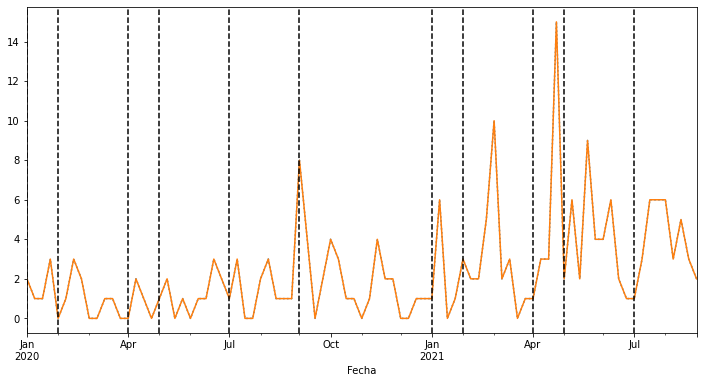

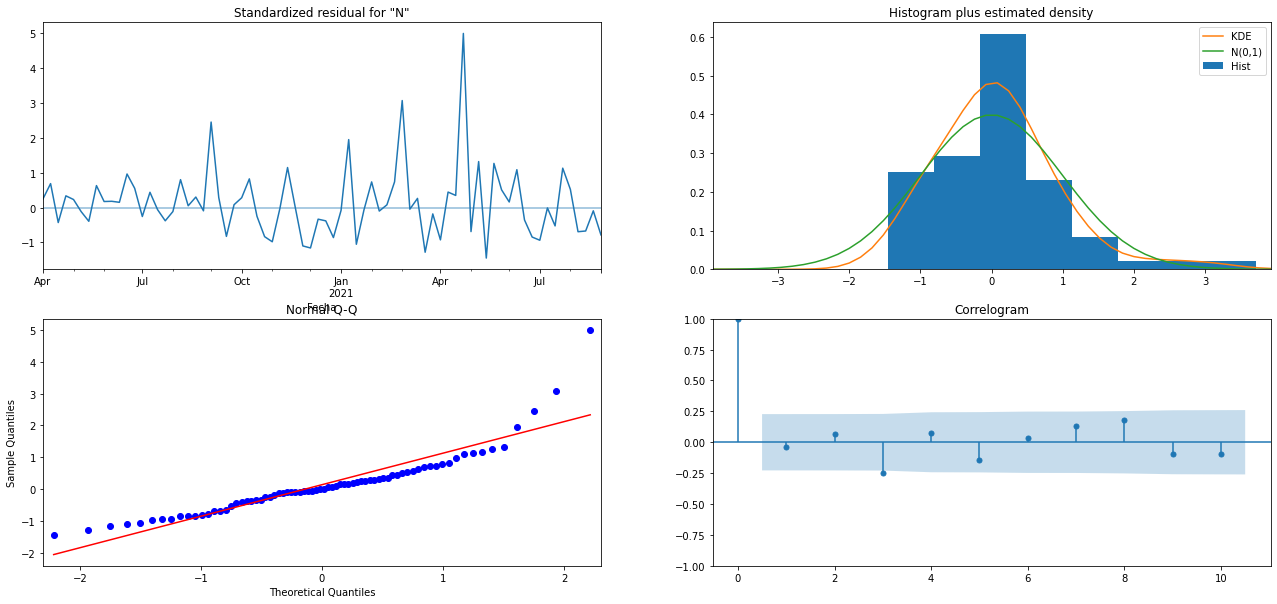

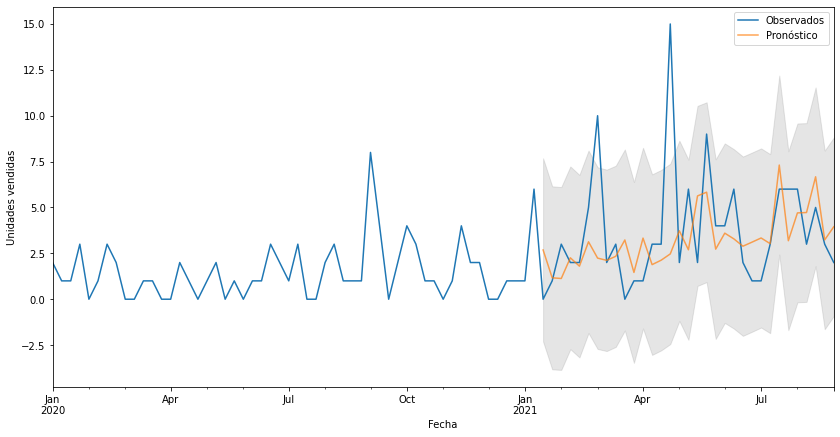

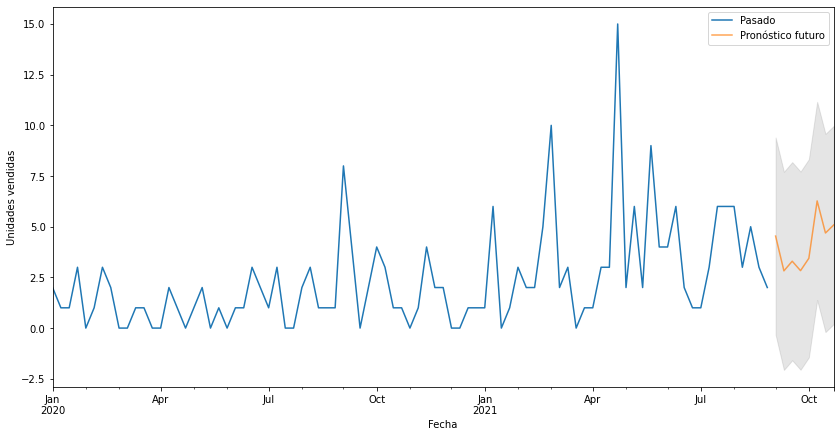

In [43]:
grafica_tendencia('OTRO','2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)

In [44]:
final_predictions_otro = predicted_df('OTRO', '2020-01-06','2021-01-18', True, 1,1,1,1,1,1,12, 8)
final_predictions_otro['Tipo Final'] = 'OTRO'

In [45]:
final_predictions = pd.concat([final_predictions_pijama,
                               final_predictions_bata,
                               final_predictions_filipina,
                               final_predictions_overol,
                               final_predictions_pantalon,
                               final_predictions_gorro,
                               final_predictions_cubre,
                               final_predictions_otro]
                              )
final_predictions.reset_index(inplace=True)
final_predictions.rename(columns={'index':'Fecha'}, inplace=True)
final_predictions['predicted_mean'] = final_predictions['predicted_mean'].round()

In [46]:
final_predictions['Fecha'] = pd.to_datetime(final_predictions['Fecha'],format = '%Y%m%d')

In [47]:
data_temp_recientes = final_data_ventas_clasif[(final_data_ventas_clasif['Temporada']=='G5')|(final_data_ventas_clasif['Temporada']=='G10')]
data_temp_recientes = data_temp_recientes[['Fecha','Tipo Final','Clave principal', 'Descripción del Producto', 'Número de Unidades', 'Utilidad', 'Temporada']]

In [48]:
final_predictions

,Fecha,predicted_mean,Tipo Final
0,2021-09-06,161.0,PIJAMA
1,2021-09-13,127.0,PIJAMA
2,2021-09-20,126.0,PIJAMA
3,2021-09-27,138.0,PIJAMA
4,2021-10-04,147.0,PIJAMA
...,...,...,...
59,2021-09-27,3.0,OTRO
60,2021-10-04,4.0,OTRO
61,2021-10-11,7.0,OTRO
62,2021-10-18,5.0,OTRO


In [49]:
data_temp_recientes

,Fecha,Tipo Final,Clave principal,Descripción del Producto,Número de Unidades,Utilidad,Temporada
0,2021-02-01,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5
1,2020-06-01,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.01,G5
2,2020-08-03,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.01,G5
3,2021-04-05,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.01,G5
4,2020-01-06,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),2,808.98,G5
...,...,...,...,...,...,...,...
15956,2021-05-31,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10
15957,2021-05-31,FILIPINA,FELCWA19XXL,FILIPINA ELLIOT CABALLERO WIN ANTIBACTERIAL (C...,1,51.75,G10
15958,2021-05-31,PIJAMA,PJCMTS21XL,PIJAMA CABALLERO MET SQUARE (COLOR: VERDE LIMO...,1,74.18,G5
15959,2021-05-31,PIJAMA,PJURCSAT40S,PIJAMA URBAN CABALLERO SQUARE ANTIBACTERIAL TE...,1,86.25,G10


In [50]:
final_pred_data_compras = pd.merge(data_temp_recientes[['Tipo Final','Clave principal','Descripción del Producto', 'Número de Unidades', 'Utilidad','Temporada']], final_predictions,on=['Tipo Final'])

# CONTINUAR TABLA DE VALORES - ya se logró por tipo de producto (queda calcular semana pasada, mes pasado completo y mes año pasado completo)

In [51]:
final_pred_data_compras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114960 entries, 0 to 114959
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Tipo Final                114960 non-null  object        
 1   Clave principal           114960 non-null  object        
 2   Descripción del Producto  114960 non-null  object        
 3   Número de Unidades        114960 non-null  int32         
 4   Utilidad                  114960 non-null  object        
 5   Temporada                 114960 non-null  object        
 6   Fecha                     114960 non-null  datetime64[ns]
 7   predicted_mean            114960 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 7.5+ MB


In [52]:
final_pred_data_compras

,Tipo Final,Clave principal,Descripción del Producto,Número de Unidades,Utilidad,Temporada,Fecha,predicted_mean
0,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-06,32.0
1,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-13,32.0
2,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-20,44.0
3,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-27,35.0
4,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-10-04,37.0
...,...,...,...,...,...,...,...,...
114955,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-09-27,3.0
114956,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-04,4.0
114957,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-11,7.0
114958,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-18,5.0


In [53]:
def complementary_analysis (df):
    week = datetime.timedelta(weeks=1)
    for i in range(53):
        df[f'{i} semana'] = final_pred_data_compras['Fecha'] - i*week
    df.drop_duplicates(subset=['Clave principal', 'Fecha'], inplace=True)
    return df

In [54]:
complementary_analysis(final_pred_data_compras)

,Tipo Final,Clave principal,Descripción del Producto,Número de Unidades,Utilidad,Temporada,Fecha,predicted_mean,0 semana,1 semana,...,43 semana,44 semana,45 semana,46 semana,47 semana,48 semana,49 semana,50 semana,51 semana,52 semana
0,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-06,32.0,2021-09-06,2021-08-30,...,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05,2020-09-28,2020-09-21,2020-09-14,2020-09-07
1,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-13,32.0,2021-09-13,2021-09-06,...,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05,2020-09-28,2020-09-21,2020-09-14
2,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-20,44.0,2021-09-20,2021-09-13,...,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05,2020-09-28,2020-09-21
3,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-09-27,35.0,2021-09-27,2021-09-20,...,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05,2020-09-28
4,BATA,BBLT00S,BATA BALTIMORE TINK (COLOR: BLANCO/TALLA: S),1,215.02,G5,2021-10-04,37.0,2021-10-04,2021-09-27,...,2020-12-07,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-09-27,3.0,2021-09-27,2021-09-20,...,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05,2020-09-28
114956,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-04,4.0,2021-10-04,2021-09-27,...,2020-12-07,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12,2020-10-05
114957,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-11,7.0,2021-10-11,2021-10-04,...,2020-12-14,2020-12-07,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19,2020-10-12
114958,OTRO,CHLBCWA01XXL,CHALECO LABANDA CABALLERO WIN ANTIBACTERIAL (C...,1,48.75,G10,2021-10-18,5.0,2021-10-18,2021-10-11,...,2020-12-21,2020-12-14,2020-12-07,2020-11-30,2020-11-23,2020-11-16,2020-11-09,2020-11-02,2020-10-26,2020-10-19


In [58]:
final_pred_data_compras_bata = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='BATA']
final_pred_data_compras_pantalon = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='PANTALON']
final_pred_data_compras_pijama = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='PIJAMA']
final_pred_data_compras_filipina = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='FILIPINA']
final_pred_data_compras_gorro = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='GORRO']
final_pred_data_compras_cubre = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='CUBRE']
final_pred_data_compras_otro = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='OTRO']
final_pred_data_compras_overol = final_pred_data_compras[final_pred_data_compras['Tipo Final']=='OVEROL']


for i in range(53):
    for t in tipo_producto_interesante(final_data_ventas_clasif):
        list1 = list(final_pred_data_compras[final_pred_data_compras['Tipo Final']==f'{t}']['Clave principal'])
        list2 = list(final_pred_data_compras[final_pred_data_compras['Tipo Final']==f'{t}'][f'{i} semana'])
        list3 = []
        for l in list2:
            l2 = str(l)
            list3.append(re.findall('\d{4}-\d{2}-\d{2}',l2))
        list4 = [x for y in list3 for x in y]
        dict_test = list(zip(list1,list4))
        test = data_temp_recientes[data_temp_recientes['Tipo Final']==f'{t}']
        test_margins = test.pivot_table(index=['Fecha'], values='Número de Unidades', columns='Clave principal',fill_value=0, aggfunc=np.sum, dropna=True,margins=True )
        modelos = list(test_margins.columns[:-1])
        for modelo in modelos:
            test_margins[modelo] = (test_margins[modelo]/test_margins['All']*100)
        test_margins = test_margins.transpose()
        new_columns= []
        old_columns = list(test_margins.columns)
        n = len(test_margins.columns)-1
        for l in range(n):
             new_columns.append(test_margins.columns[l].strftime('%Y-%m-%d'))
        dict_col = dict(zip(old_columns,new_columns))
        test_margins.rename(columns=dict_col, inplace=True)
        s = []
        for d in dict_test:
            try:
                x = test_margins.loc[d[0],d[1]]
                s.append(x)
            except KeyError:
                x = 0
                s.append(x)
        if t == 'BATA':
            final_pred_data_compras_bata[f'{i} semana %'] = s
        elif t == 'PANTALON':
            final_pred_data_compras_pantalon[f'{i} semana %'] = s
        elif t == 'OVEROL':
            final_pred_data_compras_overol[f'{i} semana %'] = s
        elif t == 'FILIPINA':
            final_pred_data_compras_filipina[f'{i} semana %'] = s
        elif t == 'PIJAMA':
            final_pred_data_compras_pijama[f'{i} semana %'] = s
        elif t == 'CUBRE':
            final_pred_data_compras_cubre[f'{i} semana %'] = s
        elif t == 'OTRO':
            final_pred_data_compras_otro[f'{i} semana %'] = s
        elif t == 'GORRO':
            final_pred_data_compras_gorro[f'{i} semana %'] = s

<ipython-input-58-4cf5504e0aa5>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_pred_data_compras_bata[f'{i} semana %'] = s
<ipython-input-58-4cf5504e0aa5>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_pred_data_compras_cubre[f'{i} semana %'] = s
<ipython-input-58-4cf5504e0aa5>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [59]:
final_pred_data_compras = pd.concat([final_pred_data_compras_bata, final_pred_data_compras_pantalon,final_pred_data_compras_pijama,
                                     final_pred_data_compras_filipina, final_pred_data_compras_gorro,final_pred_data_compras_cubre,
                                     final_pred_data_compras_otro, final_pred_data_compras_overol])

In [60]:
final_pred_data_compras.drop(['0 semana','0 semana %'], axis=1, inplace=True)

In [ ]:
final_pred_data_compras.to_csv('C:/Users/Sofía Aceves Osuna/ironhack/final_project/almostfinaltest.csv')

In [61]:
final_pred_data_compras[['1 semana %','2 semana %','3 semana %','4 semana %','5 semana %','6 semana %','7 semana %','8 semana %','9 semana %',
    '10 semana %','11 semana %','12 semana %','13 semana %','14 semana %','15 semana %','16 semana %','17 semana %','18 semana %','19 semana %',
    '20 semana %','21 semana %','22 semana %','23 semana %','24 semana %','25 semana %','26 semana %','27 semana %','28 semana %','29 semana %',
    '30 semana %','31 semana %','32 semana %','33 semana %','34 semana %','35 semana %','36 semana %','37 semana %','38 semana %','39 semana %',
    '40 semana %','41 semana %','42 semana %','43 semana %','44 semana %','45 semana %','46 semana %','47 semana %','48 semana %','49 semana %',
    '50 semana %','51 semana %','52 semana %']] = final_pred_data_compras[['1 semana %','2 semana %','3 semana %','4 semana %','5 semana %','6 semana %','7 semana %','8 semana %','9 semana %',
    '10 semana %','11 semana %','12 semana %','13 semana %','14 semana %','15 semana %','16 semana %','17 semana %','18 semana %','19 semana %',
                     '20 semana %','21 semana %','22 semana %','23 semana %','24 semana %','25 semana %','26 semana %','27 semana %','28 semana %','29 semana %',
                     '30 semana %','31 semana %','32 semana %','33 semana %','34 semana %','35 semana %','36 semana %','37 semana %','38 semana %','39 semana %',
                     '40 semana %','41 semana %','42 semana %','43 semana %','44 semana %','45 semana %','46 semana %','47 semana %','48 semana %','49 semana %',
                     '50 semana %','51 semana %','52 semana %']].apply(pd.to_numeric)
print(final_pred_data_compras.dtypes)

Tipo Final                   object
Clave principal              object
Descripción del Producto     object
Número de Unidades            int32
Utilidad                     object
                             ...   
48 semana %                 float64
49 semana %                 float64
50 semana %                 float64
51 semana %                 float64
52 semana %                 float64
Length: 112, dtype: object


In [62]:
# POR RESOLVER CÓMO SE TRATARÁ EL TEMA DE PREDECIR A MÁS ALLÁ DE UNA SEMANA
final_pred_data_compras['Semana pasada %'] = .25*final_pred_data_compras['1 semana %']
final_pred_data_compras['Mes pasado %'] = .25*(((final_pred_data_compras['1 semana %']) + (final_pred_data_compras['2 semana %']) + (final_pred_data_compras['3 semana %']) + (final_pred_data_compras['4 semana %']))/4)
final_pred_data_compras['Mes del año pasado %'] = .5*(((final_pred_data_compras['49 semana %']) + (final_pred_data_compras['50 semana %']) + (final_pred_data_compras['51 semana %']) + (final_pred_data_compras['52 semana %']))/4)
final_pred_data_compras['Porcentaje Final'] = ((final_pred_data_compras['Mes del año pasado %']) + (final_pred_data_compras['Mes pasado %']) + (final_pred_data_compras['Semana pasada %']))
final_pred_data_compras['Decisión'] = round(((final_pred_data_compras['Porcentaje Final'])/100)*(final_pred_data_compras['predicted_mean']+5))

In [63]:
final_pred_data_compras.to_csv('C:/Users/Sofía Aceves Osuna/ironhack/final_project/almostfinaltest2.csv')

In [ ]:
df_display = final_pred_data_compras[final_pred_data_compras['Fecha']=='2021-09-06'][['Tipo Final', 'Clave principal', 'Descripción del Producto',
                                                                        'predicted_mean', 'Semana pasada %', 'Mes pasado %', "Mes del año pasado %", "Porcentaje Final", "Decisión"]]

In [ ]:
len(df_display)